In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
import os
import requests
from collections import defaultdict
from scipy import interpolate
import csv
import pandas as pd
from scipy import integrate

Loading data from SPECTRA_parameters.dat (index, ra, dec, z, fracdev_g, petroR50_r, petroR90_r, eclass, myindex)

In [2]:
# Define empty lists to store the data
data_lists = []
# Open the .dat file for reading
with open("SPECTRA_parameters.dat", "r") as file:
    # Iterate through each line in the file
    for line in file:
        # Split the line into individual values using space as the delimiter
        values = line.split()
        #Convert the values to floats and append them to the data_lists
        data_lists.append([float(value) for value in values])
        
data_array = np.array(data_lists)

# Now, data_lists contains the data as a list of lists
# Each inner list represents a row of data with numerical values

Data from each .dat file within SPECTRA directory stored in a dictionary, where the keys are the index to each galaxy

In [3]:
#define dictionary to store spectral data in
spectra = {}

#directory that data is stored in
dir = r"C:\Users\julia\Documents\GradCourses\Galaxies_ASTR_5533\project_1\SPECTRA"

#lists all files in the directory dir
filelist = os.listdir(dir)

for filename in filelist:
    if filename.endswith(".dat"):
        file_path = os.path.join(dir, filename)
        spec = []
        
        #open and read the file 
        with open(file_path, "r") as file:
            for line in file:
                values=line.split()
                try:
                    spec.append([float(value) for value in values])
                    
                except ValueError:
                    continue
        if spec:
            data = np.array(spec)
            #splitting the name of file to use the numbers as the "keys" to my dictionary
            index = filename.split("-")[1].split(".")[0]
            spectra[index] = data

In [4]:
#define a dict to store filtered spectra
filtered_spec= {}

column = 3
for key, data in spectra.items():
    mask = data[:,column] > 0
    filtered_data = data[mask]
    filtered_spec[key] = filtered_data

Downloading filter data:

In [5]:
g_url = 'https://classic.sdss.org/dr7/instruments/imager/filters/g.dat'
r_url = 'https://classic.sdss.org/dr7/instruments/imager/filters/r.dat'

g = requests.get(g_url)
r = requests.get(r_url)

g_lines = g.text.split('\n')
r_lines = r.text.split('\n')

g_res = []
g_wvln = []

r_res = []
r_wvln = []

for line in g_lines:
    if not line.startswith('#'):
        columns = line.split()
        if len(columns) >= 3:
            wavelength = columns[0]
            resp = columns[2]
            
        g_res.append(resp)
        g_wvln.append(wavelength)

g_resp = [float(value) for value in g_res]
g_wavlen = [float(value) for value in g_wvln]

for line in r_lines:
    if not line.startswith('#'):
        columns = line.split()
        if len(columns) >= 3:
            wavelength = columns[0]
            resp = columns[2]
            
        r_res.append(resp)
        r_wvln.append(wavelength)
        
r_resp = [float(value) for value in r_res]
r_wavlen = [float(value) for value in r_wvln]

Calculating the observed magnitudes for both r and g-band:

In [6]:
##need to interpolate filter data so I can estimate the filter response at the exact wavelength of my spectral data
#filter data:
#mean_lambda_g, mean_resp_g, mean_lambda_r, mean_resp_r
#spectral data:
#filtered_spectra[i][0] --> this is the wavelength column, the 'i' to filter through each galaxy, filtered_spectra[i][1] --> reddening corrected flux column 

# Dictionaries to store obs magnitude values in, as well as the interpolated filter responses
Mobs_r = {}
Mobs_g = {}

#data iterates through each array (galaxy) in filtered_Spectra
for key, data in filtered_spec.items():
    # Extract wavelengths and fluxes from each galaxy
    wavlen_obs = data[:, 0]
    flux = data[:, 1]
     
    # Calculate differential wavelength for each galaxy
    dlambda_r = np.gradient(wavlen_obs)
    dlambda_g = np.gradient(wavlen_obs)

    # Use interpolation to estimate filter response at galaxy's wavelengths
    #this interpolates the response values at the positions of my wavelengths in wavelen_obs
    #for each wavelength in wavelen_obs, it finds the closest wavelengths in mean_lambda_r/g, and performs linear interpolation b/w the respons values corresponding to those two closest
    #wavelengths to estimate the response at the given wavelength in wavelen_obs
    interp_resp_r = np.interp(wavlen_obs, r_wavlen, r_resp)
    interp_resp_g = np.interp(wavlen_obs, g_wavlen, g_resp)

    #filt_resp_r[key] = interp_resp_r
    r_int = np.trapz(flux*interp_resp_r*(wavlen_obs**2)*dlambda_r, wavlen_obs)
    r_mobs = -2.5 * np.log(r_int)
    Mobs_r[key] = r_mobs

    #filt_resp_g[key] = interp_resp_g
    g_int = np.trapz(flux*interp_resp_g*(wavlen_obs**2)*dlambda_g, wavlen_obs)
    g_mobs = -2.5 * np.log(g_int)
    Mobs_g[key] = g_mobs

In [7]:
z_dict = {}  # Dictionary to store redshifts

for key, data in filtered_spec.items():
    index_match = int(key)  # Convert key to an integer
    z = data_array[data_array[:, 0] == index_match, 3][0]  # Find the corresponding redshift
    z_dict[key] = z  # Store the redshift in a dictionary

    # Now you can use the redshift (z) to calculate the rest frame wavelengths
   # wavlen_obs = data[:, 0]
    #wave_rest = wavlen_obs / (1 + z)

In [8]:
Mrest_r = {}
Mrest_g = {}

for key, data in filtered_spec.items():
    wavlen_obs = data[:,0]
    flux = data[:, 1]
    
    z = z_dict[key]
        
    wavrest = wavlen_obs / (1+z)
    
    # Calculate differential wavelength for each galaxy
    dlambda_rest = np.gradient(wavrest)
    dlambda_g_rest = np.gradient(wavrest)
        
    interp_rest_r = np.interp(wavrest, r_wavlen, r_resp)
    interp_rest_g = np.interp(wavrest, g_wavlen, g_resp)
        
        #r_filtresp[key] = interp_rest_r
        #g_filtresp[key] = interp_rest_g
        
    r_int = np.trapz(flux*interp_rest_r*(wavrest**2)*dlambda_rest, wavrest)
    g_int = np.trapz(flux*interp_rest_g*(wavrest**2)*dlambda_g_rest, wavrest)
        
    r_mrest = -2.5 * np.log(r_int)
    g_mrest = -2.5 * np.log(g_int)
     
        
    Mrest_r[key] = r_mrest
    Mrest_g[key] = g_mrest

In [9]:
# Create dictionaries to store the differences in magnitudes
K_r = {}
K_g = {}

# Iterate through the galaxies in your dictionaries
for key in Mobs_r:
    if key in Mrest_r and key in Mobs_g and key in Mrest_g:
        # Calculate the difference in magnitudes for each filter
        K_r[key] = abs(Mobs_r[key] - Mrest_r[key])
        K_g[key] = abs(Mobs_g[key] - Mrest_g[key])

In [10]:
fracdev_g = {}

for row in data_array:
    key1 = f"{int(float(row[0])):04d}"
    key = key1.strip()
    value = row[4]
    fracdev_g[key] = value

In [11]:
from collections import defaultdict

# Define your redshift bins (modify these to match your data)
bin_edges = [0.0, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20, 0.22, 0.24, 0.26, 0.28]

# Create a dictionary to store the median values for each bin
K_med_r = defaultdict(list)
K_med_g = defaultdict(list)

# Iterate through the redshift bins
for i in range(len(bin_edges) - 1):
    bin_start = bin_edges[i]
    bin_end = bin_edges[i + 1]

    # Collect the K_r values within the current redshift bin
    kr_values = [kr for key, kr in K_r.items() if bin_start <= z_dict[key] < bin_end]
    kg_values = [kg for key, kg in K_g.items() if bin_start <= z_dict[key] < bin_end]
    # Calculate the median of K_r values within the bin
    med_r = np.median(kr_values)
    med_g = np.median(kg_values)
    
    # Store the median value for this bin
    K_med_r[(bin_start, bin_end)] = med_r
    K_med_g[(bin_start, bin_end)] = med_g

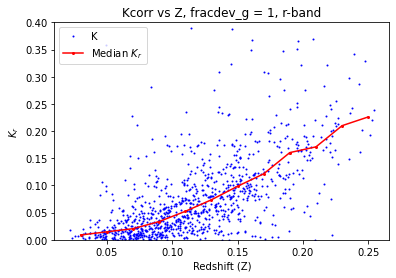

In [12]:
# Your code for setting bin_edges
bin_edges = [0.0, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20, 0.22, 0.24, 0.26, 0.28]
#K_med_r = defaultdict(list)

z_values = []
kr_values = []

for key in fracdev_g:
    cleaned_key = key.strip()
    if cleaned_key in z_dict and cleaned_key in K_r:
        z = z_dict[cleaned_key]
        if fracdev_g[cleaned_key] == 1:
            z_values.append(z)
            kr_values.append(K_r[cleaned_key])

# Plot the actual K_r values versus redshift
plt.plot(z_values, kr_values, marker='o', linestyle='', color='blue', markersize = 1,label='K')

bin_centers = []
Kcorr_r_med1 = []

for i in range(len(bin_edges) - 1):
    bin_start = bin_edges[i]
    bin_end = bin_edges[i + 1]

    # Collect the K_r values within the current redshift bin
    kr_values_inbin = [kr for z, kr in zip(z_values, kr_values) if bin_start <= z < bin_end]

    if kr_values_inbin:
        med_r = np.median(kr_values_inbin)
        bin_centers.append((bin_start + bin_end) / 2)
        Kcorr_r_med1.append(med_r)
        K_med_r[(bin_start, bin_end)] = med_r

# Plot the median K_r values
plt.plot(bin_centers, Kcorr_r_med1, marker='o', linestyle='-', color='red', markersize = 2, label='Median $K_r$')

# Your code for setting labels and legend
plt.xlabel('Redshift (Z)')
plt.ylabel('$K_r$')
plt.ylim(0, 0.4)
plt.title("Kcorr vs Z, fracdev_g = 1, r-band")
plt.legend()
plt.savefig("kcorr_r_fracdev1.png")
plt.show()

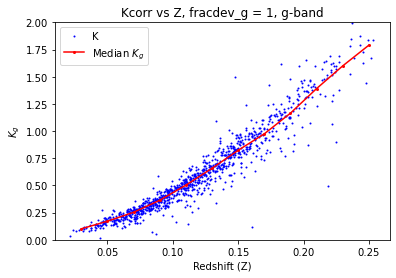

In [13]:
z_values_g = []
kg_values = []

for key in fracdev_g:
    cleaned_key = key.strip()
    if cleaned_key in z_dict and cleaned_key in K_r:
        z = z_dict[cleaned_key]
        if fracdev_g[cleaned_key] == 1:
            z_values_g.append(z)
            kg_values.append(K_g[cleaned_key])
kg = np.array(z_values_g) + np.array(kg_values)
# Plot the actual K_r values versus redshift
plt.plot(z_values_g, kg_values, marker='o', linestyle='', color='blue', markersize = 1,label='K')

bin_centers_g = []
Kcorr_g_med1 = []

for i in range(len(bin_edges) - 1):
    bin_start = bin_edges[i]
    bin_end = bin_edges[i + 1]

    # Collect the K_r values within the current redshift bin
    kg_values_inbin = [kg for z, kg in zip(z_values_g, kg_values) if bin_start <= z < bin_end]

    if kg_values_inbin:
        med_g = np.median(kg_values_inbin)
        bin_centers_g.append((bin_start + bin_end) / 2)
        Kcorr_g_med1.append(med_g)
        K_med_g[(bin_start, bin_end)] = med_g

g_kcorr = np.array(Kcorr_g_med1) + np.array(bin_centers_g)
# Plot the median K_r values
plt.plot(bin_centers_g, Kcorr_g_med1, marker='o', linestyle='-', color='red', markersize = 2, label='Median $K_g$')

# Your code for setting labels and legend
plt.xlabel('Redshift (Z)')
plt.ylabel('$K_g$')
plt.ylim(0, 2)
plt.title("Kcorr vs Z, fracdev_g = 1, g-band")
plt.legend()
plt.savefig("kcorr_g_fracdev1.png")
plt.show()

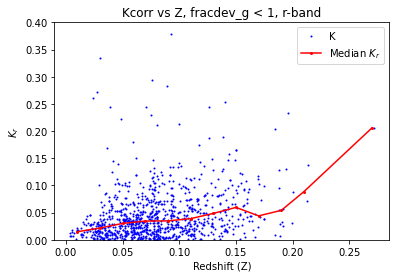

In [14]:
K_med_rlt1 = defaultdict(list)
z_values_lt1 = []
kr_values_lt1 = []

for key in fracdev_g:
    cleaned_key = key.strip()
    if cleaned_key in z_dict and cleaned_key in K_r:
        z = z_dict[cleaned_key]
        if fracdev_g[cleaned_key] < 1:
            z_values_lt1.append(z)
            kr_values_lt1.append(K_r[cleaned_key])

# Plot the actual K_r values versus redshift
plt.plot(z_values_lt1, kr_values_lt1, marker='o', linestyle='', color='blue', markersize = 1,label='K')

bin_centers_rlt1 = []
Kcorr_r_medlt1 = []

for i in range(len(bin_edges) - 1):
    bin_start = bin_edges[i]
    bin_end = bin_edges[i + 1]

    # Collect the K_r values within the current redshift bin
    kr_values_inbin = [kr for z, kr in zip(z_values_lt1, kr_values_lt1) if bin_start <= z < bin_end]

    if kr_values_inbin:
        med_r = np.median(kr_values_inbin)
        bin_centers_rlt1.append((bin_start + bin_end) / 2)
        Kcorr_r_medlt1.append(med_r)
        K_med_rlt1[(bin_start, bin_end)] = med_r

# Plot the median K_r values
plt.plot(bin_centers_rlt1, Kcorr_r_medlt1, marker='o', linestyle='-', color='red', markersize = 2, label='Median $K_r$')

# Your code for setting labels and legend
plt.xlabel('Redshift (Z)')
plt.ylabel('$K_r$')
plt.ylim(0, 0.4)
plt.title("Kcorr vs Z, fracdev_g < 1, r-band")
plt.legend()
plt.savefig("kcorr_r_fracdevLT1.png")
plt.show()

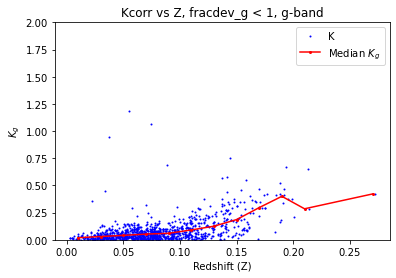

In [15]:
z_values_glt1 = []
kg_values_lt1 = []

for key in fracdev_g:
    cleaned_key = key.strip()
    if cleaned_key in z_dict and cleaned_key in K_r:
        z = z_dict[cleaned_key]
        if fracdev_g[cleaned_key] < 1:
            z_values_glt1.append(z)
            kg_values_lt1.append(K_g[cleaned_key])

# Plot the actual K_r values versus redshift
plt.plot(z_values_glt1, kg_values_lt1, marker='o', linestyle='', color='blue', markersize = 1,label='K')

bin_centers_glt1 = []
Kcorr_g_medlt1 = []

for i in range(len(bin_edges) - 1):
    bin_start = bin_edges[i]
    bin_end = bin_edges[i + 1]

    # Collect the K_r values within the current redshift bin
    kg_values_inbin = [kg for z, kg in zip(z_values_glt1, kg_values_lt1) if bin_start <= z < bin_end]

    if kg_values_inbin:
        med_g = np.median(kg_values_inbin)
        bin_centers_glt1.append((bin_start + bin_end) / 2)
        Kcorr_g_medlt1.append(med_g)
        K_med_g[(bin_start, bin_end)] = med_g

# Plot the median K_r values
plt.plot(bin_centers_glt1, Kcorr_g_medlt1, marker='o', linestyle='-', color='red', markersize = 2, label='Median $K_g$')

# Your code for setting labels and legend
plt.xlabel('Redshift (Z)')
plt.ylabel('$K_g$')
plt.ylim(0, 2)
plt.title("Kcorr vs Z, fracdev_g < 1, g-band")
plt.legend()
plt.savefig("kcorr_g_fracdevLT1.png")
plt.show()

In [16]:
edges = [0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20, 0.22, 0.24, 0.26]

#"actual" z-values:
z_values #r band fracdev = 1
z_values_g #g band fracdev = 1 
z_values_lt1 #r band frac dev < 1
z_values_glt1 #g band frac dev < 1

bin_centers
bin_centers_g
bin_centers_rlt1
bin_centers_glt1

#Kcorr median values:
Kcorr_r_med1 #fracdev = 1; r band
Kcorr_g_med1 #fracdev = 1; g band
K_med_rlt1 #fracdev < 1; r band
Kcorr_g_medlt1 #fracdev < 1; g band

[0.018829867529262856,
 0.03023388016610795,
 0.04072324845634867,
 0.052305407804020376,
 0.05975698719949207,
 0.09049085935134826,
 0.12509450009318357,
 0.18585009106445938,
 0.29627478490791503,
 0.39990147081608285,
 0.28529072290501745,
 0.42166994404085756]

In [17]:
k_r_1 = interpolate.interp1d(bin_centers, Kcorr_r_med1, bounds_error=False) #, kind = 'cubic')
k_r_lt1 = interpolate.interp1d(bin_centers_rlt1, Kcorr_r_medlt1, bounds_error=False) #, kind = 'cubic')
k_g_1 = interpolate.interp1d(bin_centers_g, Kcorr_g_med1, bounds_error=False) #, kind = 'cubic')
k_g_lt1 = interpolate.interp1d(bin_centers_glt1, Kcorr_g_medlt1, bounds_error=False) #, kind = 'cubic')

In [18]:
sampleA = pd.read_csv('sampleA1_jerobe.csv')
sampleB = pd.read_csv('sampleB1_jerobe.csv')

Cutting down sample size to be within proper redshift range:

In [19]:
sampleA_z = sampleA[(sampleA["z"]<0.26)&(sampleA["z"]>0.01)]
# Reset the index of the filtered DataFrame
sampleA_z = sampleA_z.reset_index(drop=True)
sampleB_z = sampleB[(sampleB["z"]<0.26)&(sampleB["z"]>0.01)]
sampleB_z = sampleB_z.reset_index(drop=True)

Interpolating for each sample:

In [20]:
k_r_a = k_r_1(sampleA_z['z'])
sampleA_z["k_r"] = k_r_a

k_g_a = k_g_1(sampleA_z['z'])
sampleA_z["k_g"] = k_g_a

k_r_b = k_r_lt1(sampleB_z['z'])
sampleB_z["k_r"] = k_r_b

k_g_b = k_g_lt1(sampleB_z['z'])
sampleB_z["k_g"] = k_g_b

In [21]:
def e_int(z):
    omega_m = 0.3
    omega_lambda = 0.7
    e = ((1+z)**2*(1+omega_m*z) - omega_lambda*z*(2+z))**(-1./2.)
    return e

def properdist(z):
    H_0 = 70 #km/s/Mpc
    c = 3*10**5 #km/s
    d_p = (c/H_0)*integrate.quad(e_int,0,z)[0] #Mpc
    return d_p #Mpc

def luminosity_dist(z):
    d_p = properdist(z)
    d_L = (1+z)*d_p
    return d_L*10**6. #parsec

def angular_dist(z):
    d_p = properdist(z)
    d_A = d_p/(1+z)
    return d_A*10**3 #kiloparsec

In [22]:
#calculating luminosity dist:
sampleA_z["d_L"] = sampleA_z["z"].apply(lambda x: luminosity_dist(x))
sampleB_z["d_L"] = sampleB_z["z"].apply(lambda x: luminosity_dist(x))

#calculating angular dist:
sampleA_z["d_A"] = sampleA_z["z"].apply(lambda x: luminosity_dist(x))
sampleB_z["d_A"] = sampleB_z["z"].apply(lambda x: luminosity_dist(x))

#calculating abs magnitude:
sampleA_z["M_g"] =  sampleA_z["devmag_g"] - 5*np.log10(sampleA_z["d_L"]) + 5 -  sampleA_z["k_g"] - sampleA_z["extinction_g"]
sampleA_z["M_r"] =  sampleA_z["devmag_r"] - 5*np.log10(sampleA_z["d_L"]) + 5 -  sampleA_z["k_r"] - sampleA_z["extinction_r"]

sampleB_z["M_g"] =  sampleB_z["expmag_g"] - 5*np.log10(sampleB_z["d_L"]) + 5 -  sampleB_z["k_g"] - sampleB_z["extinction_g"]
sampleB_z["M_r"] =  sampleB_z["expmag_r"] - 5*np.log10(sampleB_z["d_L"]) + 5 -  sampleB_z["k_r"] - sampleB_z["extinction_r"]

#calculating effective radius
sampleA_z["r_eff_g"]=sampleA_z["devrad_g"]*np.sqrt(sampleA_z["devab_g"]) / 206265
sampleA_z["r_eff_r"]=sampleA_z["devrad_r"]*np.sqrt(sampleA_z["devab_r"]) / 206265

sampleB_z["r_eff_g"]=sampleB_z["exprad_g"]*np.sqrt(sampleB_z["expab_g"]) / 206265
sampleB_z["r_eff_r"]=sampleB_z["exprad_r"]*np.sqrt(sampleB_z["expab_r"]) / 206265

#calculating effective radius in arcsecs:
sampleA_z["r_eff_g_arc"]=sampleA_z["devrad_g"]*np.sqrt(sampleA_z["devab_g"]) 
sampleA_z["r_eff_r_arc"]=sampleA_z["devrad_r"]*np.sqrt(sampleA_z["devab_r"]) 

sampleB_z["r_eff_g_arc"]=sampleB_z["exprad_g"]*np.sqrt(sampleB_z["expab_g"]) 
sampleB_z["r_eff_r_arc"]=sampleB_z["exprad_r"]*np.sqrt(sampleB_z["expab_r"]) 

#calculating physical size:
sampleA_z['size_g'] = sampleA_z['r_eff_g']*sampleA_z['d_L']
sampleA_z['size_r'] = sampleA_z['r_eff_r']*sampleA_z['d_L']
sampleB_z['size_g'] = sampleB_z['r_eff_g']*sampleB_z['d_L']
sampleB_z['size_r'] = sampleB_z['r_eff_r']*sampleB_z['d_L']

#calculating surf brightness:
sampleA_z["sb_g"] = sampleA_z["devmag_g"] - sampleA_z["k_g"] + 5*np.log10(sampleA_z["r_eff_g_arc"]) + 2.5*np.log10(2*np.pi) - 10*np.log10(1+sampleA_z["z"])
sampleA_z["sb_r"] = sampleA_z["devmag_r"] - sampleA_z["k_r"] + 5*np.log10(sampleA_z["r_eff_r_arc"]) + 2.5*np.log10(2*np.pi) - 10*np.log10(1+sampleA_z["z"])

sampleB_z["sb_g"] = sampleB_z["devmag_g"] - sampleB_z["k_g"] + 5*np.log10(sampleB_z["r_eff_g_arc"]) + 2.5*np.log10(2*np.pi) - 10*np.log10(1+sampleB_z["z"])
sampleB_z["sb_r"] = sampleB_z["devmag_r"] - sampleB_z["k_r"] + 5*np.log10(sampleB_z["r_eff_r_arc"]) + 2.5*np.log10(2*np.pi) - 10*np.log10(1+sampleB_z["z"])

C:\Users\julia\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [23]:
sampleA_z.to_csv("../sampleA_proj1.csv",index=False)
sampleB_z.to_csv("../sampleB_proj1.csv",index=False)

Plotting:

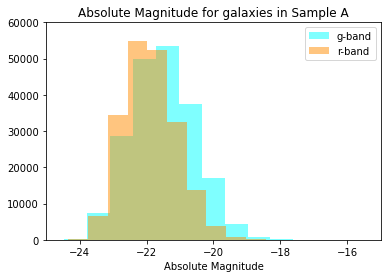

In [26]:
plt.hist(sampleA_z["M_g"],bins=20,alpha=0.5,label="g-band", color = 'cyan')
plt.hist(sampleA_z["M_r"],bins=20,alpha=0.5,label="r-band", color = 'darkorange')
plt.title("Absolute Magnitude for galaxies in Sample A")
plt.xlabel("Absolute Magnitude")
plt.xlim(-25,-15)
plt.ylim(0, 60000)
plt.legend()
plt.savefig("abs_mag_sampleA.png")

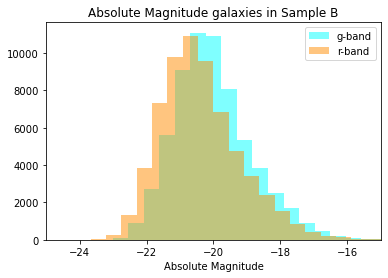

In [28]:
plt.hist(sampleB_z["M_g"],bins=40,alpha=0.5,label="g-band", color = 'cyan')
plt.hist(sampleB_z["M_r"],bins=40,alpha=0.5,label="r-band", color = 'darkorange')
plt.title("Absolute Magnitude galaxies in Sample B")
plt.xlabel("Absolute Magnitude")
plt.xlim(-25,-15)
#plt.ylim(0, 60000)
plt.legend()
plt.savefig("abs_mag_sampleB.png")

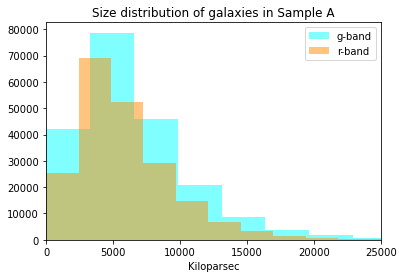

In [29]:
plt.hist(sampleA_z["size_g"],alpha=0.5,bins=50,label="g-band", color = 'cyan')
plt.hist(sampleA_z["size_r"],alpha=0.5,bins=25,label="r-band", color = 'darkorange')
plt.title("Size distribution of galaxies in Sample A")
plt.xlabel("Kiloparsec")
#plt.ylabel("Count")
plt.legend()
plt.xlim(0,25000)
plt.savefig("phys_size_sampleA.png")

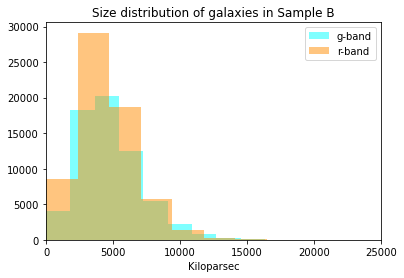

In [30]:
plt.hist(sampleB_z["size_g"],alpha=0.5,bins=140,label="g-band", color = 'cyan')
plt.hist(sampleB_z["size_r"],alpha=0.5,bins=125,label="r-band", color = 'darkorange')
plt.title("Size distribution of galaxies in Sample B")
plt.xlabel("Kiloparsec")
#plt.ylabel("Count")
plt.legend()
plt.xlim(0,25000)
plt.savefig("phys_size_sampleB.png")

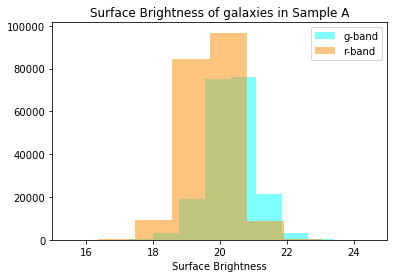

In [31]:
plt.hist(sampleA_z["sb_g"],alpha=0.5,bins=40,label="g-band", color = 'cyan')
plt.hist(sampleA_z["sb_r"],alpha=0.5,bins=25,label="r-band", color = 'darkorange')
plt.title("Surface Brightness of galaxies in Sample A")
plt.xlabel("Surface Brightness")
#plt.ylabel("Count")
plt.legend()
plt.xlim(15,25)
plt.savefig("sb_sampleA.png")

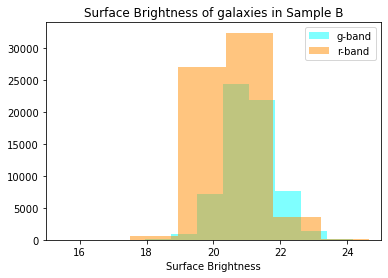

In [32]:
# Assuming sampleB_z is your DataFrame
sb_r_values = sampleB_z["sb_r"]

# Filter out infinite values
valid_sb_r = sb_r_values[np.isfinite(sb_r_values)]

# Assuming sampleB_z is your DataFrame
sb_g_values = sampleB_z["sb_g"]

# Filter out infinite values
valid_sb_g = sb_g_values[np.isfinite(sb_g_values)]

plt.hist(valid_sb_g,alpha=0.5,bins=40,label="g-band", color = 'cyan')
plt.hist(valid_sb_r,alpha=0.5,bins=25,label="r-band", color = 'darkorange')
plt.title("Surface Brightness of galaxies in Sample B")
plt.xlabel("Surface Brightness")
#plt.ylabel("Count")
plt.legend()
plt.xlim(15,25)
plt.savefig("sb_sampleB.png")